<a href="https://colab.research.google.com/github/MattGarner03/Stock-Market-Prediction/blob/main/Earnings_Transcript_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysing calls:   0%|          | 0/71 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (10685 > 512). Running this sequence through the model will result in indexing errors
<ipython-input-3-4ebf446c0763>:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=model.dtype != torch.float32):


Saved plot ➜ /content/sentiment_over_time.png


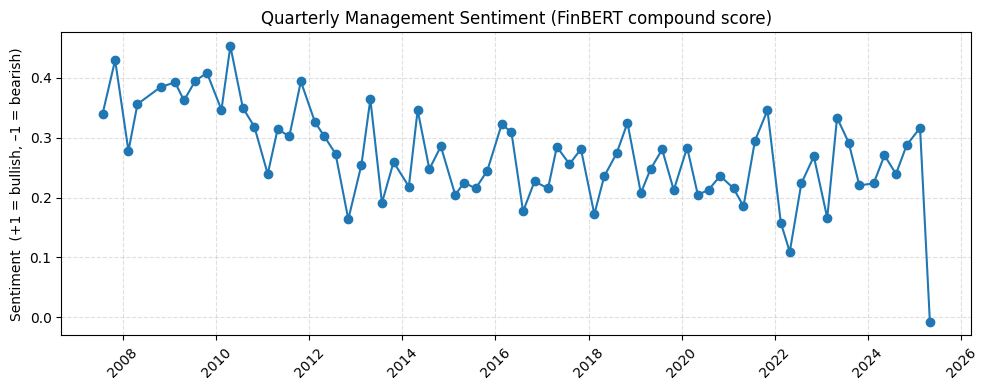

In [ ]:
# -----------------------------------------------------------
#  EQUITY-EARNINGS  |  QUARTER-LEVEL SENTIMENT PIPELINE
#  ----------------------------------------------------------
#  Requirements:
#  pip install -U pandas matplotlib tqdm transformers torch

# too slow going to better try and utilise the GPU
#  ----------------------------------------------------------
import re, os, json, pathlib, datetime as dt
from pathlib import Path
from collections import defaultdict

import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax

#############################################################
# 1) CONFIG
#############################################################
SOURCE_FILE      = Path("/content/EQIX_transcripts.txt")   
OUTPUT_DIR       = Path("./calls_split")                    # where the individual .txt files go
PLOT_PATH        = Path("./sentiment_over_time.png")        # optional chart
MODEL_NAME       = "ProsusAI/finbert"                       # finance-tuned RoBERTa-large
BATCH_SENTENCES  = 32                                       # GPU/CPU memory knob

OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

#############################################################
# 2) HELPERS
#############################################################
PATTERN = re.compile(
    r"^=+\s*(?P<year>\d{4})\s*Q(?P<qtr>[1-4])\s*\((?P<ts>[\d\- :]+)\)\s*=+",
    re.MULTILINE)

def split_calls(text: str):
    """
    Yield (header, body) tuples for every call in the master file.
    """
    matches = list(PATTERN.finditer(text))
    for i, m in enumerate(matches):
        start = m.end()
        end   = matches[i+1].start() if i+1 < len(matches) else len(text)
        header = m.group(0).strip("=")
        body   = text[start:end].strip()
        yield header, body

def normalise_timestamp(ts_str: str):
    # 2025-02-12 17:30:00  -> datetime
    return dt.datetime.fromisoformat(ts_str.strip())

#############################################################
# 3) LOAD & SPLIT 
#############################################################
raw = SOURCE_FILE.read_text(encoding="utf-8", errors="ignore")
calls_meta, calls_text = [], {}

matches = list(PATTERN.finditer(raw))
for i, m in enumerate(matches):
    start = m.end()
    end   = matches[i+1].start() if i+1 < len(matches) else len(raw)

    # pull structured info directly from m
    year = int(m["year"])
    qtr  = int(m["qtr"])
    ts   = normalise_timestamp(m["ts"])
    call_id = f"{year}-Q{qtr}"

    body = raw[start:end].strip()
    out_path = OUTPUT_DIR / f"{call_id}.txt"
    out_path.write_text(body, encoding="utf-8")

    calls_meta.append(
        {"call_id": call_id,
         "year": year, "quarter": qtr, "timestamp": ts,
         "path": out_path}
    )
    calls_text[call_id] = body


#############################################################
# 4) LOAD MODEL
#############################################################
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

label_map = {0: "negative", 1: "neutral", 2: "positive"}

#############################################################
# 5) SENTIMENT INFERENCE  – 512-token chunks
#############################################################
MAX_LEN = 512          # model context
BATCH_SENTENCES = 128  # turn the GPU up to 11

def chunkify(text):
    """
    Greedy pack tokens into 512-token blocks so we hit the GPU fewer times.
    """
    tokens = tokenizer(text,
                       add_special_tokens=False,
                       return_attention_mask=False,
                       return_offsets_mapping=False)["input_ids"]
    for i in range(0, len(tokens), MAX_LEN):
        yield tokens[i:i+MAX_LEN]

@torch.inference_mode()
def call_sentiment(call_text: str):
    # --- create 512-token chunks -------------------------------------------------
    chunks = list(chunkify(call_text))
    scores = torch.zeros(len(chunks), 3, dtype=torch.float32, device=DEVICE)

    # --- mini-batch over the chunks ---------------------------------------------
    for i in range(0, len(chunks), BATCH_SENTENCES):
        batch_ids = chunks[i:i+BATCH_SENTENCES]
        inputs = {
            "input_ids":       torch.nn.utils.rnn.pad_sequence(
                                   [torch.tensor(x, device=DEVICE) for x in batch_ids],
                                   batch_first=True, padding_value=tokenizer.pad_token_id),
            "attention_mask":  None
        }
        inputs["attention_mask"] = (inputs["input_ids"] != tokenizer.pad_token_id)

        with torch.cuda.amp.autocast(enabled=model.dtype != torch.float32):
            logits = model(**inputs).logits           # (batch, 3)

        probs = softmax(logits, dim=-1)
        scores[i:i+len(batch_ids)] = probs

    # --- aggregate --------------------------------------------------------------
    mean_probs = scores.mean(dim=0).cpu()             # (3,)
    agg = {label_map[i]: mean_probs[i].item() for i in range(3)}
    agg["compound"] = agg["positive"] - agg["negative"]
    return agg


sentiment_rows = []
for meta in tqdm(calls_meta, desc="Analysing calls"):
    call_id = meta["call_id"]
    s = call_sentiment(calls_text[call_id])
    sentiment_rows.append({**meta, **s})

sent_df = pd.DataFrame(sentiment_rows).sort_values("timestamp")
sent_df.to_csv("quarterly_sentiment.csv", index=False)

#############################################################
# 6) VISUALISE
#############################################################
plt.figure(figsize=(10,4))
plt.plot(sent_df["timestamp"], sent_df["compound"], marker="o")
plt.title("Quarterly Management Sentiment (FinBERT compound score)")
plt.ylabel("Sentiment  (+1 = bullish, –1 = bearish)")
plt.grid(linestyle="--", alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=150)
print(f"Saved plot ➜ {PLOT_PATH.absolute()}")


# AMT

Analysing calls:   0%|          | 0/72 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (13081 > 512). Running this sequence through the model will result in indexing errors
<ipython-input-4-1b3a9d7a27fd>:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=model.dtype != torch.float32):


Saved plot ➜ /content/sentiment_over_time.png


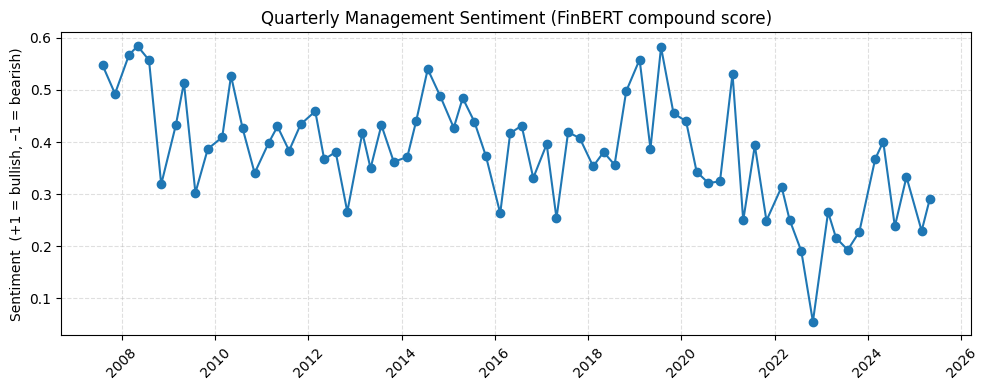

In [ ]:
from pathlib import Path
from collections import defaultdict

import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax

#############################################################
# 1) CONFIG
#############################################################
SOURCE_FILE      = Path("/content/AMT_transcripts.txt")   
OUTPUT_DIR       = Path("./calls_split")                    # where the individual .txt files go
PLOT_PATH        = Path("./sentiment_over_time.png")        # optional chart
MODEL_NAME       = "ProsusAI/finbert"                       # finance-tuned RoBERTa-large
BATCH_SENTENCES  = 32                                       # GPU/CPU memory knob

OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

#############################################################
# 2) HELPERS
#############################################################
PATTERN = re.compile(
    r"^=+\s*(?P<year>\d{4})\s*Q(?P<qtr>[1-4])\s*\((?P<ts>[\d\- :]+)\)\s*=+",
    re.MULTILINE)

def split_calls(text: str):
    """
    Yield (header, body) tuples for every call in the master file.
    """
    matches = list(PATTERN.finditer(text))
    for i, m in enumerate(matches):
        start = m.end()
        end   = matches[i+1].start() if i+1 < len(matches) else len(text)
        header = m.group(0).strip("=")
        body   = text[start:end].strip()
        yield header, body

def normalise_timestamp(ts_str: str):

    return dt.datetime.fromisoformat(ts_str.strip())

#############################################################
# 3) LOAD & SPLIT  (patched)
#############################################################
raw = SOURCE_FILE.read_text(encoding="utf-8", errors="ignore")
calls_meta, calls_text = [], {}

matches = list(PATTERN.finditer(raw))
for i, m in enumerate(matches):
    start = m.end()
    end   = matches[i+1].start() if i+1 < len(matches) else len(raw)

    # pull structured info directly from m
    year = int(m["year"])
    qtr  = int(m["qtr"])
    ts   = normalise_timestamp(m["ts"])
    call_id = f"{year}-Q{qtr}"

    body = raw[start:end].strip()
    out_path = OUTPUT_DIR / f"{call_id}.txt"
    out_path.write_text(body, encoding="utf-8")

    calls_meta.append(
        {"call_id": call_id,
         "year": year, "quarter": qtr, "timestamp": ts,
         "path": out_path}
    )
    calls_text[call_id] = body


#############################################################
# 4) LOAD MODEL
#############################################################
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

label_map = {0: "negative", 1: "neutral", 2: "positive"}

#############################################################
# 5) SENTIMENT INFERENCE  – 512-token chunks
#############################################################
MAX_LEN = 512          # model context
BATCH_SENTENCES = 128  # turn the GPU up to 11

def chunkify(text):
    """
    Greedy pack tokens into 512-token blocks so we hit the GPU fewer times.
    """
    tokens = tokenizer(text,
                       add_special_tokens=False,
                       return_attention_mask=False,
                       return_offsets_mapping=False)["input_ids"]
    for i in range(0, len(tokens), MAX_LEN):
        yield tokens[i:i+MAX_LEN]

@torch.inference_mode()
def call_sentiment(call_text: str):
    # --- create 512-token chunks -------------------------------------------------
    chunks = list(chunkify(call_text))
    scores = torch.zeros(len(chunks), 3, dtype=torch.float32, device=DEVICE)

    # --- mini-batch over the chunks ---------------------------------------------
    for i in range(0, len(chunks), BATCH_SENTENCES):
        batch_ids = chunks[i:i+BATCH_SENTENCES]
        inputs = {
            "input_ids":       torch.nn.utils.rnn.pad_sequence(
                                   [torch.tensor(x, device=DEVICE) for x in batch_ids],
                                   batch_first=True, padding_value=tokenizer.pad_token_id),
            "attention_mask":  None
        }
        inputs["attention_mask"] = (inputs["input_ids"] != tokenizer.pad_token_id)

        with torch.cuda.amp.autocast(enabled=model.dtype != torch.float32):
            logits = model(**inputs).logits           # (batch, 3)

        probs = softmax(logits, dim=-1)
        scores[i:i+len(batch_ids)] = probs

    # --- aggregate --------------------------------------------------------------
    mean_probs = scores.mean(dim=0).cpu()             # (3,)
    agg = {label_map[i]: mean_probs[i].item() for i in range(3)}
    agg["compound"] = agg["positive"] - agg["negative"]
    return agg


sentiment_rows = []
for meta in tqdm(calls_meta, desc="Analysing calls"):
    call_id = meta["call_id"]
    s = call_sentiment(calls_text[call_id])
    sentiment_rows.append({**meta, **s})

sent_df = pd.DataFrame(sentiment_rows).sort_values("timestamp")
sent_df.to_csv("quarterly_sentiment.csv", index=False)

#############################################################
# 6) VISUALISE
#############################################################
plt.figure(figsize=(10,4))
plt.plot(sent_df["timestamp"], sent_df["compound"], marker="o")
plt.title("Quarterly Management Sentiment (FinBERT compound score)")
plt.ylabel("Sentiment  (+1 = bullish, –1 = bearish)")
plt.grid(linestyle="--", alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=150)
print(f"Saved plot ➜ {PLOT_PATH.absolute()}")
